In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

tf.random.set_seed(7)

# Explore Dataset

In [3]:
train_dir = '../dataset/train/'
train_df = pd.read_csv('../dataset/train.csv')

test_dir = '../dataset/test/'

In [4]:
train_df.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [47]:
train_df.shape

(6469, 2)

In [6]:
train_df.Class.unique()

array(['Miscellaneous', 'Candle', 'Snowman', 'Airplane', 'Christmas_Tree',
       'Jacket'], dtype=object)

In [7]:
train_df.Class.value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

In [8]:
def add_path(img):
    return "../dataset/train/"+img

In [9]:
filenames = train_df.Image.apply(add_path)
encoder = LabelEncoder()
labels = encoder.fit_transform(train_df.Class).astype('int32')

dataset = tf.data.Dataset.from_tensor_slices((filenames,labels))

In [38]:
def display_images(filename):
    img = plt.imread(filen)
    plt.imshow(img)

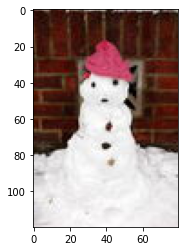

In [48]:
display_images(filenames[2])

In [10]:
pd.Series(labels).value_counts()

4    2801
2    1539
3     640
1     593
0     535
5     361
dtype: int64

In [6]:
# Preprocessing Images and convert them into tf.Data.Dataset

In [11]:
def parse_function(filename, label):
    image_str = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_str,channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    return image,label

In [12]:
def train_preprocess(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image,[16,16])
    image = tf.clip_by_value(image,0.0,1.0)
    return image,label

In [13]:
BATCH_SIZE = 128
EPOCHS = 5

In [14]:
dataset = dataset.shuffle(len(filenames))
dataset = dataset.map(parse_function, num_parallel_calls=4)
dataset = dataset.map(train_preprocess, num_parallel_calls=4)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(1)

In [15]:
validation_data = dataset.take(int(train_df.shape[0]*0.2))
training_data = dataset.skip(int(train_df.shape[0]*0.2))

In [16]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32


def create_model():
    IMAGE_SHAPE = (IMAGE_HEIGHT,IMAGE_WIDTH,3)
    base_model = tf.keras.applications.ResNet50(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
    
    pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
    output_layer = tf.keras.layers.Dense(6)
    
    model = tf.keras.models.Sequential([
    base_model,
    pooling_layer,
    output_layer
    ])
    lr = 1e-5
    optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy']

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [17]:
model = create_model()

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [19]:
history = model.fit(dataset,epochs=EPOCHS,
                    verbose=1,validation_data=validation_data,
                    callbacks=[early_stopping])

Epoch 1/5
51/51 [==============================] - 152s 3s/step - loss: 2.7545 - accuracy: 0.1544 - val_loss: 2.0295 - val_accuracy: 0.0558
Epoch 2/5
32/51 [=================>............] - ETA: 53s - loss: 2.1724 - accuracy: 0.2388

KeyboardInterrupt: 